In [1]:
import numpy as np
import pathlib
import matplotlib.pyplot as plt

import pathlib
import json
import numpy as np
import time
import matplotlib.pyplot as plt


In [2]:
def load_head_data(experiments_path):
    head_data = {}
    for task_dir in experiments_path.iterdir():
        head_data[task_dir.stem] = {}
        for seed_dir in task_dir.iterdir():
            head_mask = np.load(seed_dir / "head_mask.npy")
            head_data[task_dir.stem][seed_dir.stem] = {
                "head_mask": head_mask,
            }
    return head_data
def load_mlp_data(experiments_path):
    mlp_data = {}
    for task_dir in experiments_path.iterdir():
        mlp_data[task_dir.stem] = {}
        for seed_dir in task_dir.iterdir():
            mlp_mask = np.load(seed_dir / "mlp_mask.npy")
            mlp_importance = np.load(seed_dir / "mlp_importance.npy")
            mlp_data[task_dir.stem][seed_dir.stem] = {
                "mlp_mask": mlp_mask,
                "mlp_importance": mlp_importance
            }
    return mlp_data


In [17]:

experiments_path = pathlib.Path("../masks_results")
head_data = load_head_data(experiments_path)

experiments_path = pathlib.Path("../mlp_masks_results")
mlp_data = load_mlp_data(experiments_path)

experiments_path = pathlib.Path("../head_mlp_masks_results")
n_head_data = load_head_data(experiments_path)

experiments_path = pathlib.Path("../head_mlp_masks_results")
n_mlp_data = load_mlp_data(experiments_path)

experiments_path = pathlib.Path("../mask_experiments/masks_both_train_subset/")
nn_head_data = load_head_data(experiments_path)


In [4]:
!mkdir -p heatmaps heatmaps/all_tasks heatmaps/task_specific

# Components heatmap

In [18]:
def plot_all_task_metrics(metrics, title):
    for name in metrics[0][1].keys():
        plot_task_metrics(analyzed_metrics, name, title)


def plot_matrix(mean_matrix, stddv_matrix, x_labels, y_labels, save_path, x_title='', y_title='', colour_map=plt.cm.OrRd):
    fig, ax = plt.subplots(figsize=(9,8))
    ax.set_xlabel(x_title, labelpad=20)
    ax.set_ylabel(y_title)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.set_xticks(range(len(x_labels)))
    ax.set_yticks(range(len(y_labels)))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    ax.imshow(mean_matrix, cmap=colour_map)
    plt.tight_layout()
    for i in range(len(mean_matrix)):
        for j in range(len(mean_matrix[0])):
            mean = mean_matrix[i, j]
            std =  stddv_matrix[i, j]
            ax.text(j, i, f"{mean:.2f}\n{std:.2f}", va='center', ha='center')
    if save_path:
        fig.savefig(save_path, bbox_inches='tight')

def show_heads_heatmap(head_data, save_name):
    tasks = sorted(list(head_data.keys()))
    seeds = head_data["MNLI"].keys()
    pruned_head_results = np.zeros((len(seeds), 12, 12)) # 12 layers with 12 heads each
    for task_idx, task in enumerate(tasks):
        for seed_idx, seed in enumerate(seeds):
            pruned_head_results[seed_idx] += head_data[task][seed]["head_mask"]
    mean_pruned_heads = np.mean(pruned_head_results, axis=0)
    std_pruned_heads = np.std(pruned_head_results, axis=0, ddof=1)

    plot_matrix(mean_pruned_heads, std_pruned_heads, list(map(str, range(12))), list(map(str, range(12))), save_name, "Head", "Layer")

def show_mlps_heatmap(mlp_data, save_name):
    tasks = sorted(list(mlp_data.keys()))
    seeds = mlp_data["MNLI"].keys()
    pruned_mlps_results = np.zeros((len(seeds), 1, 12)) # 12 layers
    for task_idx, task in enumerate(tasks):
        for seed_idx, seed in enumerate(seeds):
            pruned_mlps_results[seed_idx] += mlp_data[task][seed]["mlp_mask"]
    mean_pruned_mlps = np.mean(pruned_mlps_results, axis=0)
    std_pruned_mlps = np.std(pruned_mlps_results, axis=0, ddof=1)

    plot_matrix(mean_pruned_mlps, std_pruned_mlps, list(map(str, range(12))), [], save_name, "Layer", "")

## Heads Heat map - Heads found separately setting

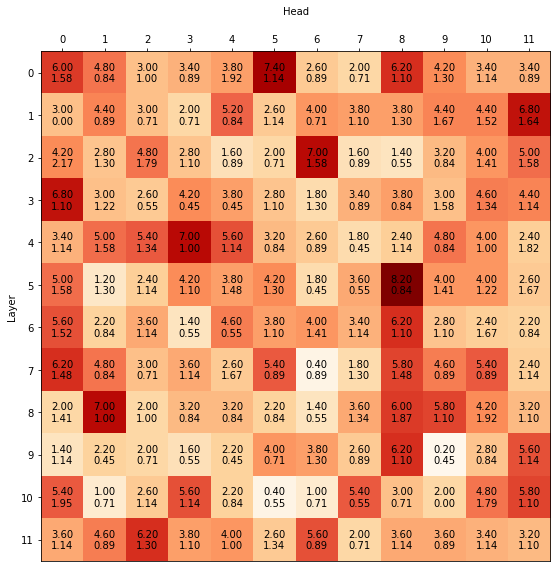

In [6]:
show_heads_heatmap(head_data, "heatmaps/all_tasks/head_heatmap_separate.pdf")

## Heads Heat map - Heads found together with MLPs setting

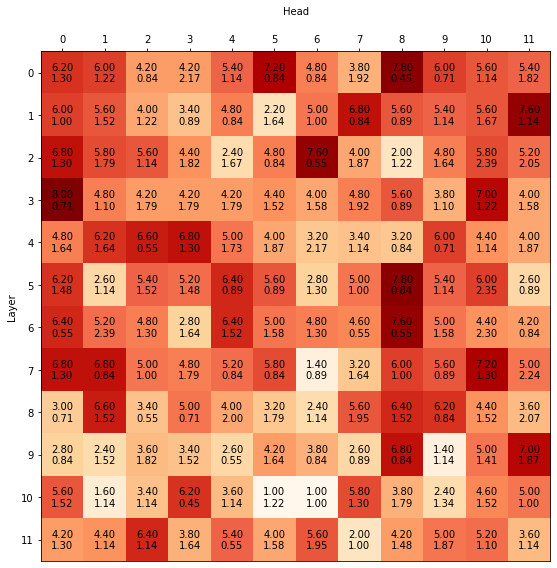

In [7]:
show_heads_heatmap(n_head_data, "heatmaps/all_tasks/head_heatmap_together.pdf")

## MLPs Heat map - MLPs found separately

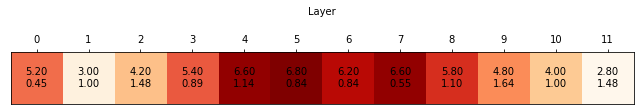

In [8]:
show_mlps_heatmap(mlp_data, "heatmaps/all_tasks/mlp_heatmap_separate.pdf")

## MLPs Heat map - MLPs found together with Heads setting

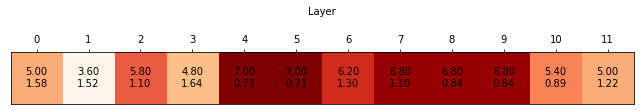

In [9]:
show_mlps_heatmap(n_mlp_data, "heatmaps/all_tasks/mlp_heatmap_together.pdf")

In [29]:
def show_task_specific_heads_heatmap(head_data, directory, save_suffix):
    tasks = sorted(list(head_data.keys()))
    seeds = head_data["MNLI"].keys()
    for task in tasks:
        pruned_head_results = np.zeros((len(seeds), 12, 12)) # 12 layers with 12 heads each
    
        for seed_idx, seed in enumerate(seeds):
            pruned_head_results[seed_idx] += head_data[task][seed]["head_mask"]
        mean_pruned_heads = np.mean(pruned_head_results, axis=0)
        std_pruned_heads = np.std(pruned_head_results, axis=0, ddof=1)

        plot_matrix(mean_pruned_heads, std_pruned_heads, list(map(str, range(12))), list(map(str, range(12))), f"{directory}/{task}_{save_suffix}", "Head", "Layer")

def show_task_specific_mlp_heatmap(mlp_data, directory, save_suffix):
    tasks = sorted(list(head_data.keys()))
    seeds = mlp_data["MNLI"].keys()
    for task in tasks:
        pruned_mlps_results = np.zeros((len(seeds), 1, 12)) # 12 layers
        for seed_idx, seed in enumerate(seeds):
            pruned_mlps_results[seed_idx] += mlp_data[task][seed]["mlp_mask"]
        mean_pruned_mlps = np.mean(pruned_mlps_results, axis=0)
        std_pruned_mlps = np.std(pruned_mlps_results, axis=0, ddof=1)

        plot_matrix(mean_pruned_mlps, std_pruned_mlps, list(map(str, range(12))), [], f"{directory}/{task}_{save_suffix}", "Layer", "")


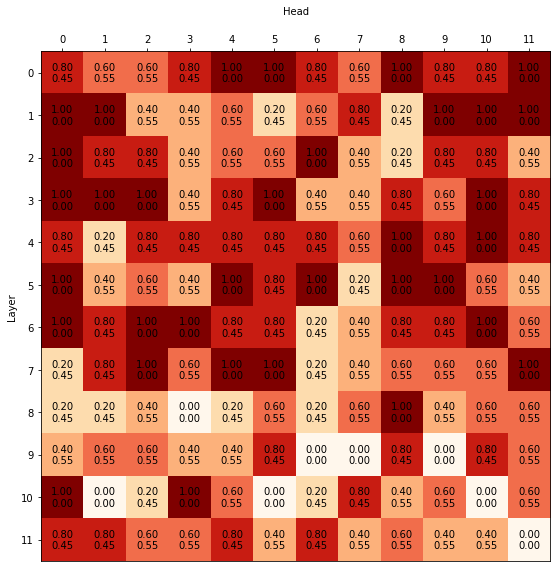

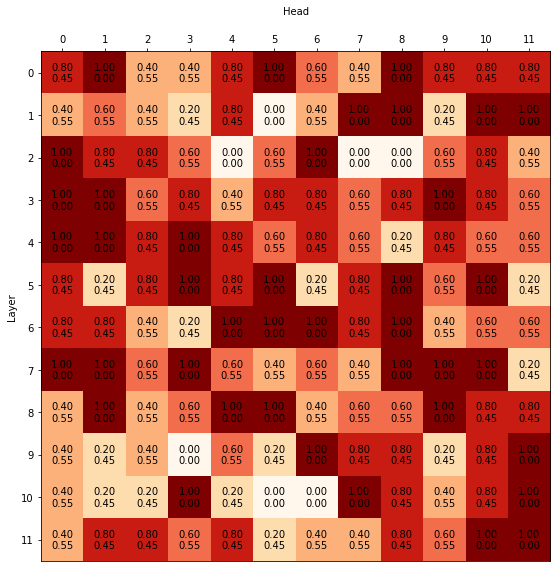

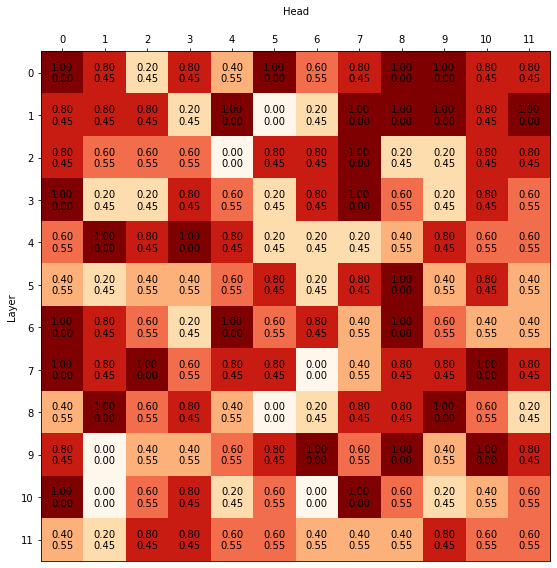

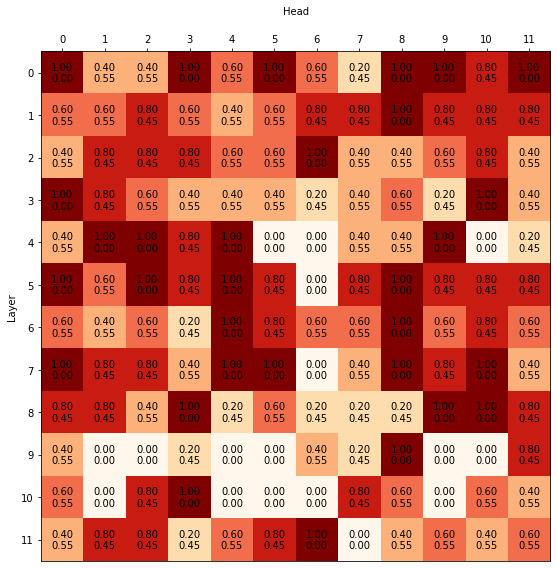

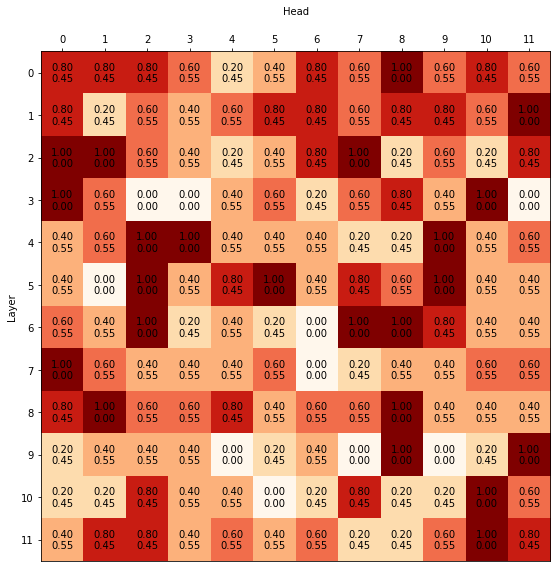

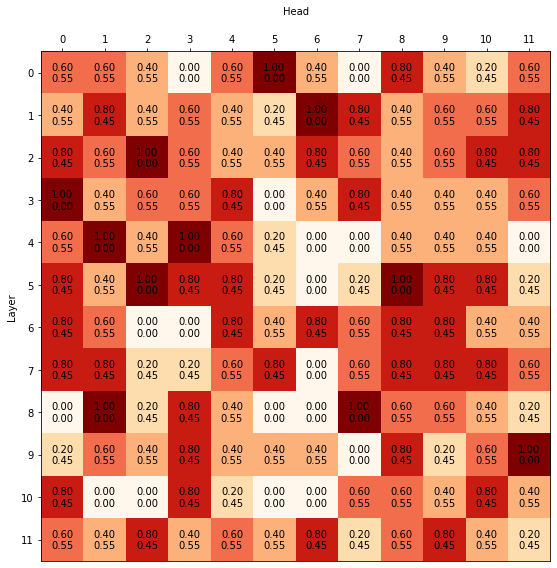

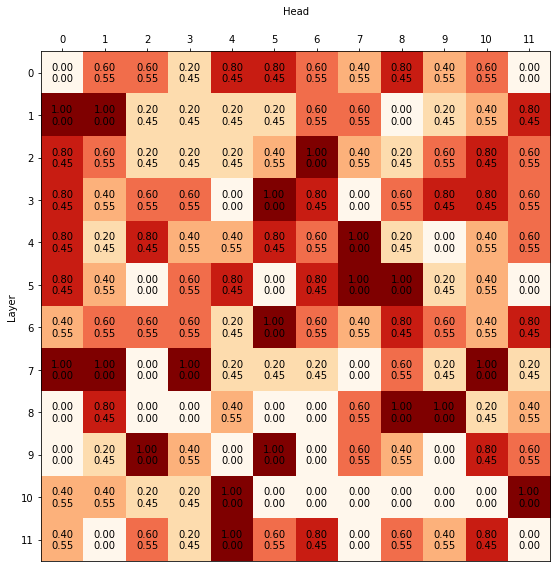

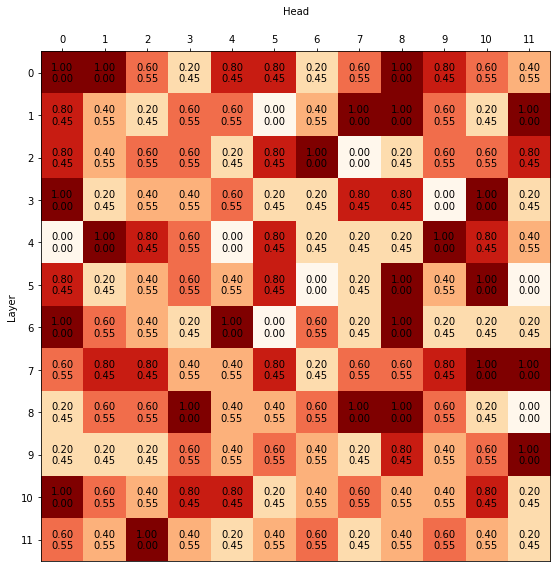

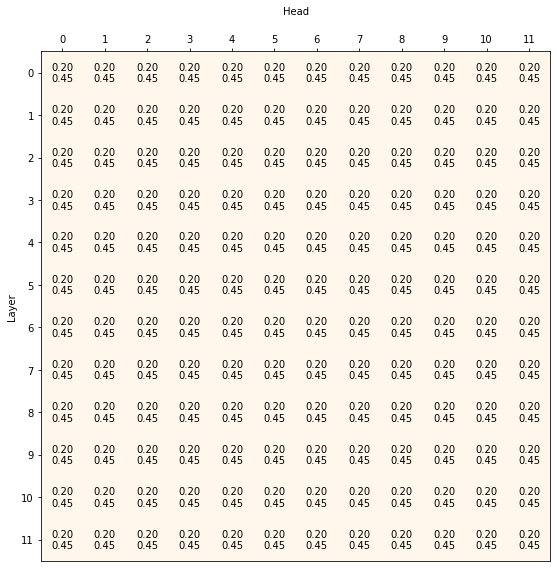

In [12]:
show_task_specific_heads_heatmap(n_head_data, "heatmaps/task_specific", "head_heatmap_together.pdf")

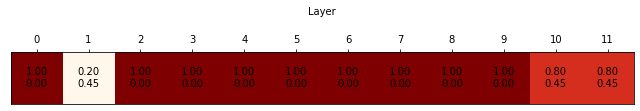

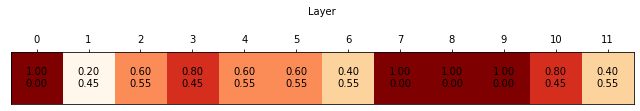

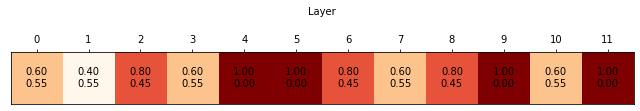

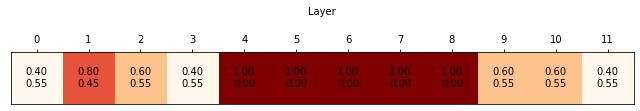

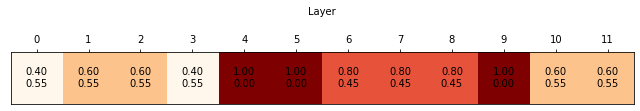

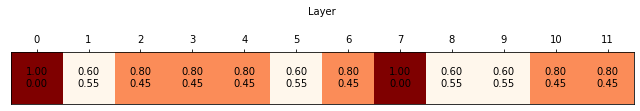

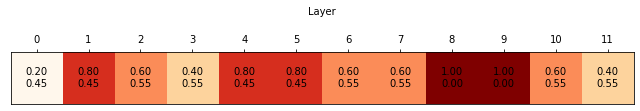

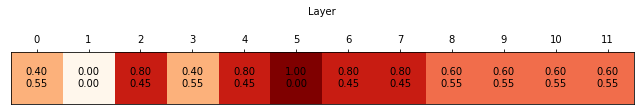

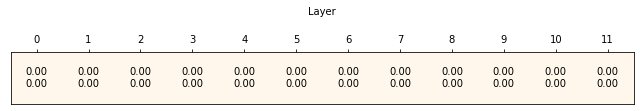

In [13]:
show_task_specific_mlp_heatmap(n_mlp_data, "heatmaps/task_specific", "mlps_heatmap_together.pdf")

# Head+MLP Masks found together in Train subset

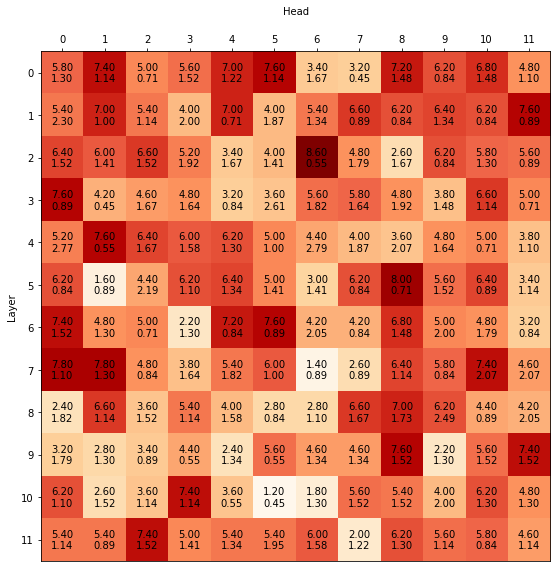

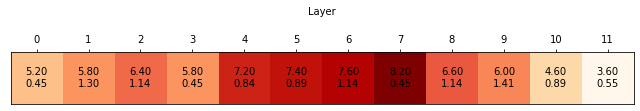

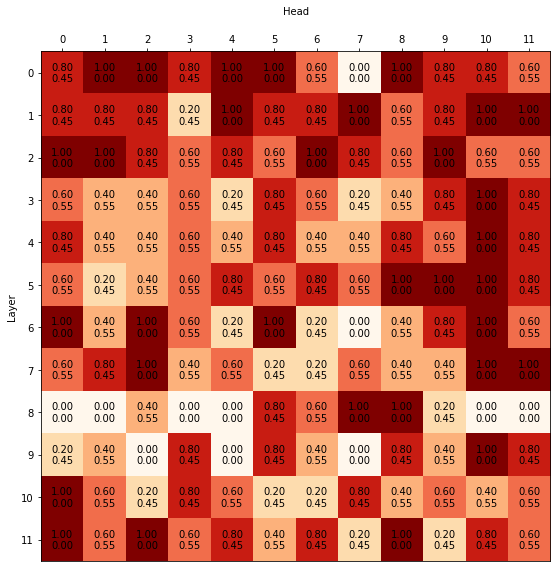

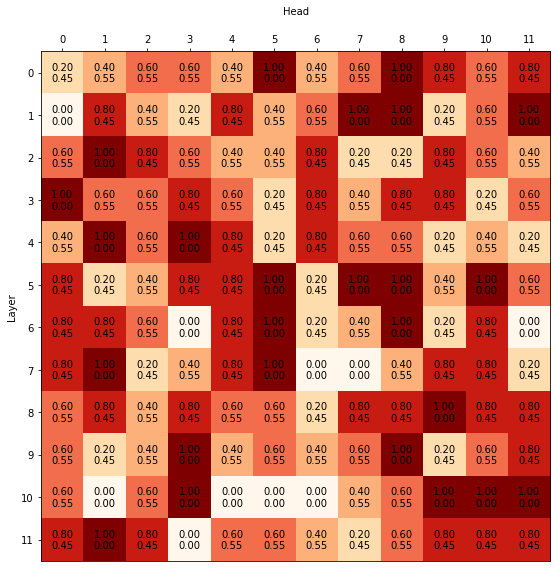

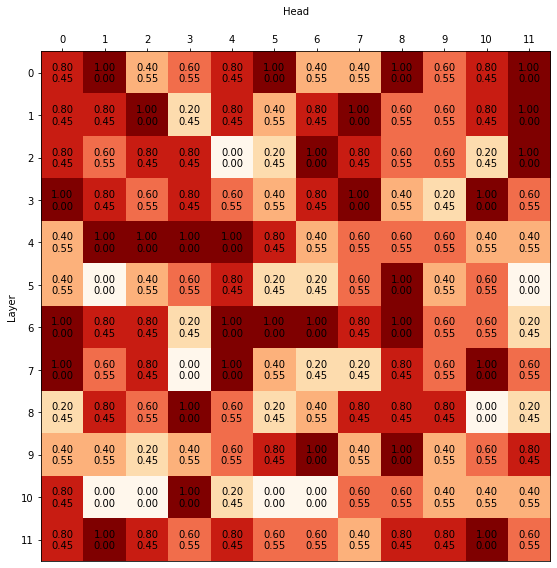

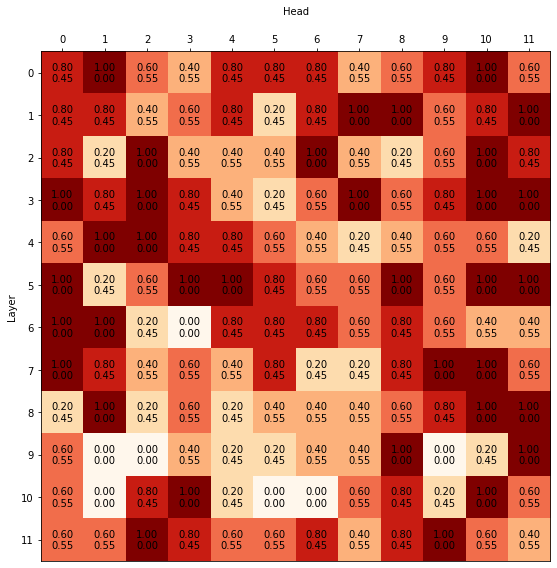

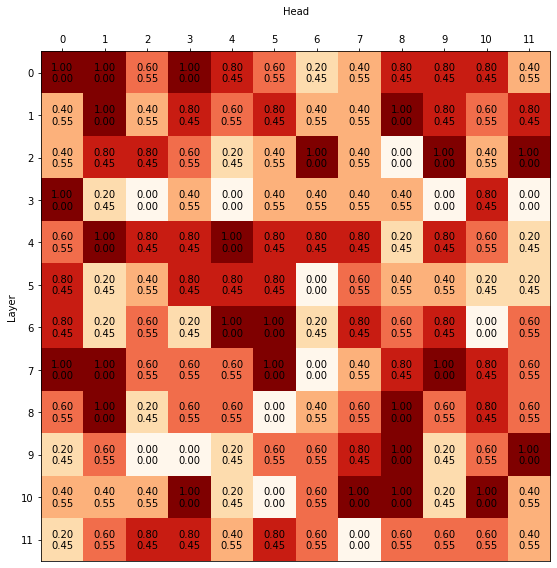

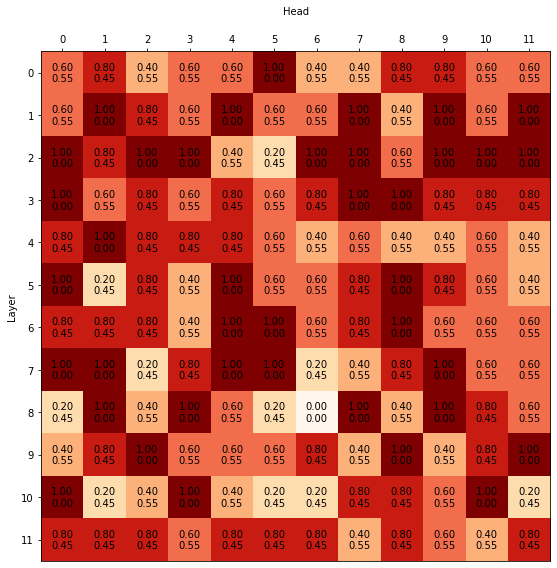

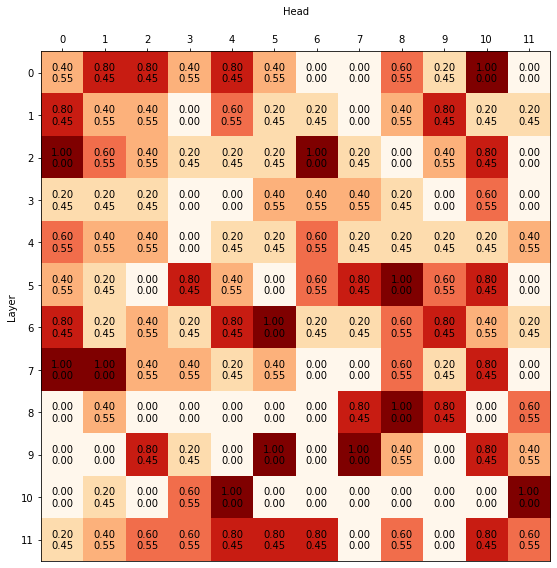

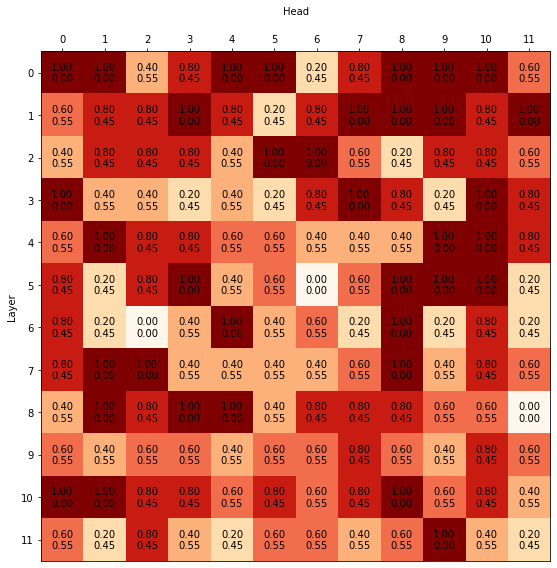

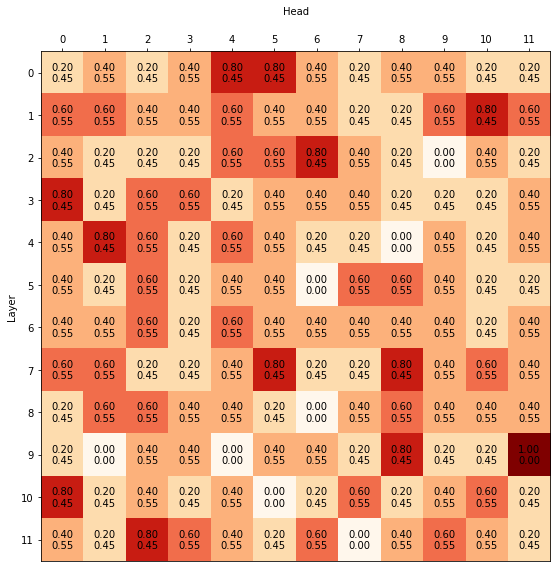

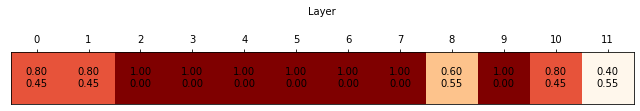

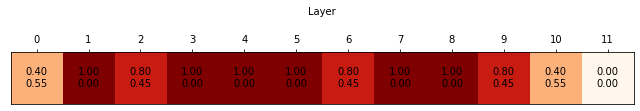

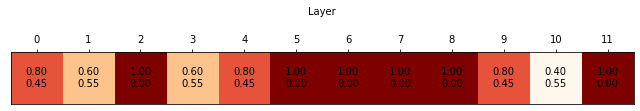

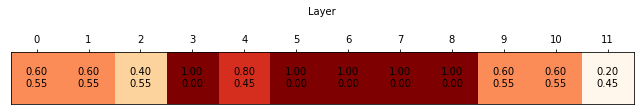

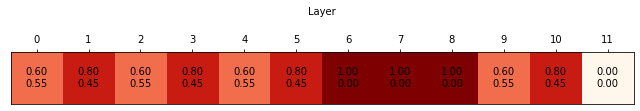

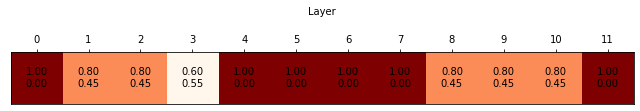

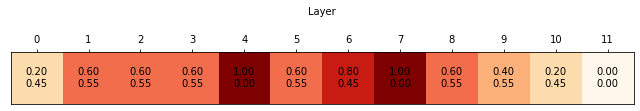

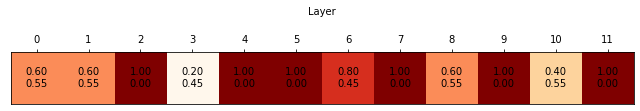

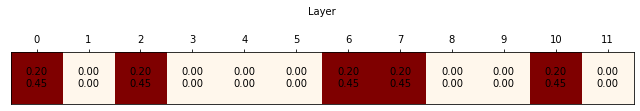

In [30]:
experiments_path = pathlib.Path("../mask_experiments/masks_both_train_subset/")
nn_mlp_data = load_mlp_data(experiments_path)
show_heads_heatmap(nn_head_data, "heatmaps/all_tasks/train_subset/head_heatmap_together_train_subset.pdf")
show_mlps_heatmap(nn_mlp_data, "heatmaps/all_tasks/train_subset/mlps_heatmap_together_train_subset.pdf")
show_task_specific_heads_heatmap(nn_head_data, "heatmaps/task_specific/train_subset", "head_heatmap_together_train_subset.pdf")
show_task_specific_mlp_heatmap(nn_mlp_data, "heatmaps/task_specific/train_subset", "mlps_heatmap_together_train_subset.pdf")

In [ ]:
# Randomly generated data for each task for sanity check.
random_head_data = {}
random_mlp_data = {}
for task in head_data.keys():
    random_head_data[task] = {}
    random_mlp_data[task] = {}
    for seed in head_data[task]:
        old_head_mask = n_head_data[task][seed]["head_mask"]
        old_mlp_mask = n_mlp_data[task][seed]["mlp_mask"]
    
        heads = int(old_head_mask.sum())
        mlps = int(old_mlp_mask.sum())

        new_head_mask = np.zeros(old_head_mask.size)
        new_mlp_mask = np.zeros(old_mlp_mask.size)
        
        heads_to_one = np.random.choice(144, (heads,), replace=False)
        mlps_to_one = np.random.choice(12, (mlps,), replace=False)
        for head in heads_to_one:
            new_head_mask[head] = 1
        for mlp in mlps_to_one:
            new_mlp_mask[mlp] = 1
        
        new_head_mask = new_head_mask.reshape(old_head_mask.shape)
        new_mlp_mask = new_mlp_mask.reshape(old_mlp_mask.shape)

        random_head_data[task][seed] = {"head_mask": new_head_mask}
        random_mlp_data[task][seed] = {"mlp_mask": new_mlp_mask}

task_overlap_attention_heads(random_head_data, None)
task_overlap_mlps(random_mlp_data, None)
show_heads_heatmap(random_head_data, None)
show_mlps_heatmap(random_mlp_data, None)